In [157]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print("cuda is available")
else:
    print("cuda is NOT available")

import numpy as np
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import time
import copy
from moving_average import moving_average_1d

from policy import PolicyNN
from nn_functions import surrogate

import sys
sys.path.append('../1_model')
from TiDE import TideModule, quantile_loss  


cuda is available


In [158]:
df_all = pd.read_csv('../0_data/merged_df_2_99_temp_depth.csv')
df_all.shape

(610615, 12)

In [159]:
nan_rows = df_all[df_all.isna().any(axis=1)]
nan_rows

,time_index,melt_pool_temperature,melt_pool_depth,scanning_speed,X,Y,Z,Dist_to_nearest_X,Dist_to_nearest_Y,Dist_to_nearest_Z,Laser_power,laser_power_number
6293,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,614.885692,2
6294,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,614.893610,2
12588,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,633.345179,3
12589,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,633.341653,3
18883,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,683.646863,4
...,...,...,...,...,...,...,...,...,...,...,...,...
598024,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,642.786355,97
604318,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,676.289806,98
604319,224.947778,NaN,NaN,7.0,17.018514,-18.933201,7.5,2.981486,1.066799,0,676.285789,98
610613,224.912038,NaN,0.0,7.0,17.029661,-18.742469,7.5,2.970339,1.257531,0,655.685110,99


In [160]:
df_all = df_all.dropna()
df_all.shape

(610417, 12)

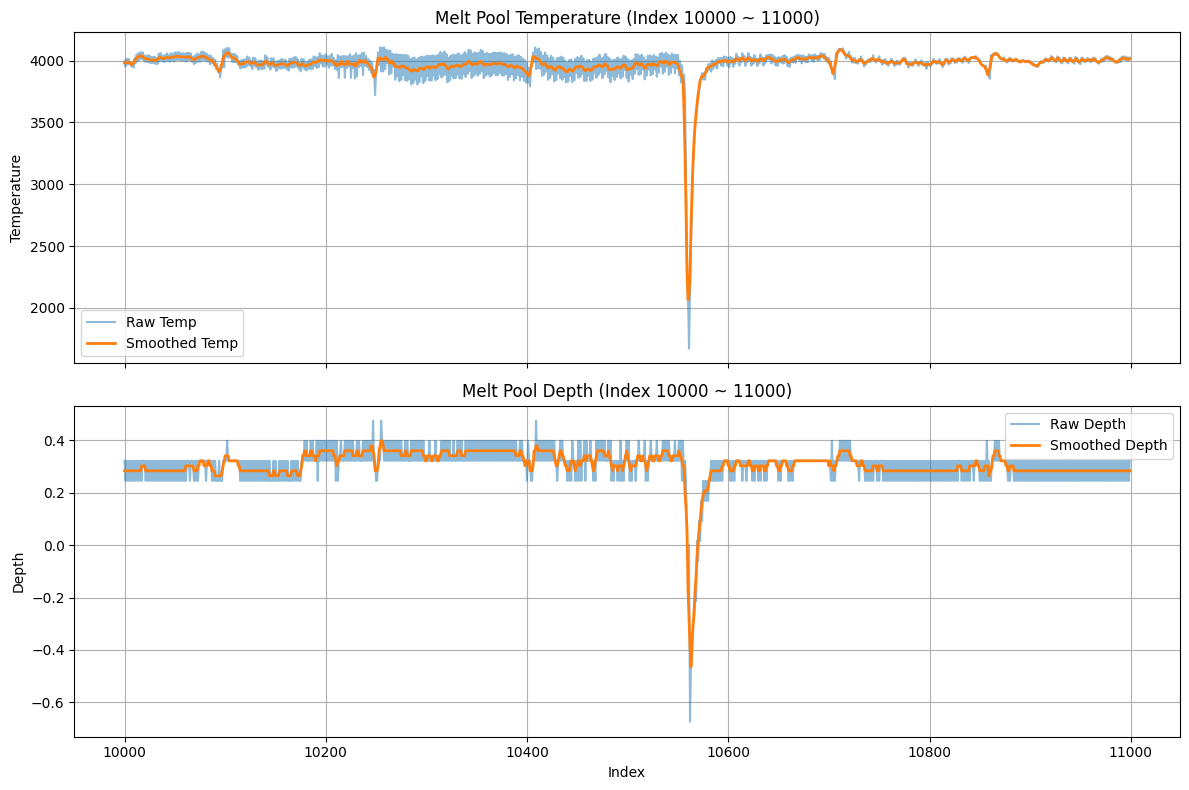

In [161]:
loc_X = df_all["X"].to_numpy().reshape(-1,1)
loc_Y = df_all["Y"].to_numpy().reshape(-1,1)
loc_Z = df_all["Z"].to_numpy().reshape(-1,1)
dist_X = df_all["Dist_to_nearest_X"].to_numpy().reshape(-1,1)
dist_Y = df_all["Dist_to_nearest_Y"].to_numpy().reshape(-1,1)
# dist_Z = df_all["Dist_to_nearest_Z"].to_numpy()[::2].reshape(-1,1)
scan_spd = df_all["scanning_speed"].to_numpy().reshape(-1,1)
laser_power = df_all["Laser_power"].to_numpy().reshape(-1,1)
laser_on_off = df_all["laser_power_number"].to_numpy().reshape(-1,1)

# apply moving average for mp temp
mp_temp_raw = df_all["melt_pool_temperature"].to_numpy()
mp_temp_mv = moving_average_1d(mp_temp_raw,4)
mp_temp = copy.deepcopy(mp_temp_raw)
mp_temp[1:-2] = mp_temp_mv
mp_temp = mp_temp.reshape(-1,1)

# apply moving average for mp depth
mp_depth_raw = df_all["melt_pool_depth"].to_numpy()
mp_depth_mv = moving_average_1d(mp_depth_raw,4)
mp_depth = copy.deepcopy(mp_depth_raw)
mp_depth[1:-2] = mp_depth_mv
mp_depth = mp_depth.reshape(-1,1)       

# Check
start = 10000
end = 11000
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(range(start, end), mp_temp_raw[start:end], label='Raw Temp', alpha=0.5)
axes[0].plot(range(start, end), mp_temp[start:end], label='Smoothed Temp', linewidth=2)
axes[0].set_title(f"Melt Pool Temperature (Index {start} ~ {end})")
axes[0].set_ylabel("Temperature")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(range(start, end), mp_depth_raw[start:end], label='Raw Depth', alpha=0.5)
axes[1].plot(range(start, end), mp_depth[start:end], label='Smoothed Depth', linewidth=2)
axes[1].set_title(f"Melt Pool Depth (Index {start} ~ {end})")
axes[1].set_xlabel("Index")
axes[1].set_ylabel("Depth")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


In [162]:
# stack input array
x_original_scale = np.concatenate((loc_Z, dist_X, dist_Y, laser_power), axis=1)
y_original_scale = np.concatenate((mp_temp, mp_depth), axis=1)

In [163]:
# scaling
x_max = np.max(x_original_scale,0).reshape(1,-1)
x_min = np.min(x_original_scale,0).reshape(1,-1) 
y_max = np.max(y_original_scale,0).reshape(1,-1) 
y_min = np.min(y_original_scale,0).reshape(1,-1)

print("x_max:", np.round(x_max, 3).tolist())
print("x_min:", np.round(x_min, 3).tolist())
print("y_max:", np.round(y_max, 3).tolist())
print("y_min:", np.round(y_min, 3).tolist())


x_max: [[7.5, 20.0, 20.0, 732.298]]
x_min: [[0.0, 0.75, 0.75, 504.26]]
y_max: [[4509.855, 0.551]]
y_min: [[436.608, -0.559]]


In [164]:
class scalers():
    def __init__(self,x_max, x_min, y_max, y_min) -> None:
        self.x_max = x_max
        self.x_min = x_min
        self.y_max = y_max
        self.y_min = y_min
        
        return None
    
    def scaler_x(self, x_original, dim_id = -1):
        if dim_id == -1:
            x_s = -1 + 2 * ((x_original - self.x_min) / (self.x_max-self.x_min))
            return x_s
        else: 
            x_s = -1 + 2 * (x_original - self.x_min[0,dim_id]) / (self.x_max[0,dim_id] - self.x_min[0,dim_id])
            return x_s
    
    def inv_scaler_x(self, x_s, dim_id = -1):
        
        if dim_id == -1:
            x_original = (x_s + 1)*0.5*(self.x_max-self.x_min) + self.x_min
            return x_original
        else: 
            x_original = (x_s + 1)*0.5*(self.x_max[0,dim_id] - self.x_min[0,dim_id]) + self.x_min[0,dim_id]
            return x_original
        
    def scaler_y(self, y_original):
        return -1 + 2 * ((y_original - self.y_min) / (self.y_max-self.y_min))
    
    def inv_scaler_y(self, y_s):
        return (y_s + 1)*0.5*(self.y_max-self.y_min) + self.y_min

In [165]:
scaler = scalers(x_max, x_min, y_max, y_min)

x_s = scaler.scaler_x(x_original_scale)
y_s = scaler.scaler_y(y_original_scale)

print("x_s range:", np.min(x_s), "to", np.max(x_s))
print("y_s range:", np.min(y_s), "to", np.max(y_s))

print("x_s shape:", x_s.shape)
print("y_s shape:", y_s.shape)

x_s range: -1.0 to 1.0
y_s range: -1.0 to 1.0
x_s shape: (610417, 4)
y_s shape: (610417, 2)


In [166]:
length = y_s.shape[0]

# y_s_ref = np.random.uniform(0.0, 1.0, size=(length, 1))

e = 0.01
y_depth_low = np.random.uniform(0.25-e, 0.25+e, size=(length, 1))
y_depth_up = np.random.uniform(0.75-e, 0.75+e, size=(length, 1))
y_s_const = np.concatenate((y_depth_low, y_depth_up), axis=1)

# print("y_s_ref shape:", y_s_ref.shape)
print("y_s_const shape:", y_s_const.shape)

y_s_const shape: (610417, 2)


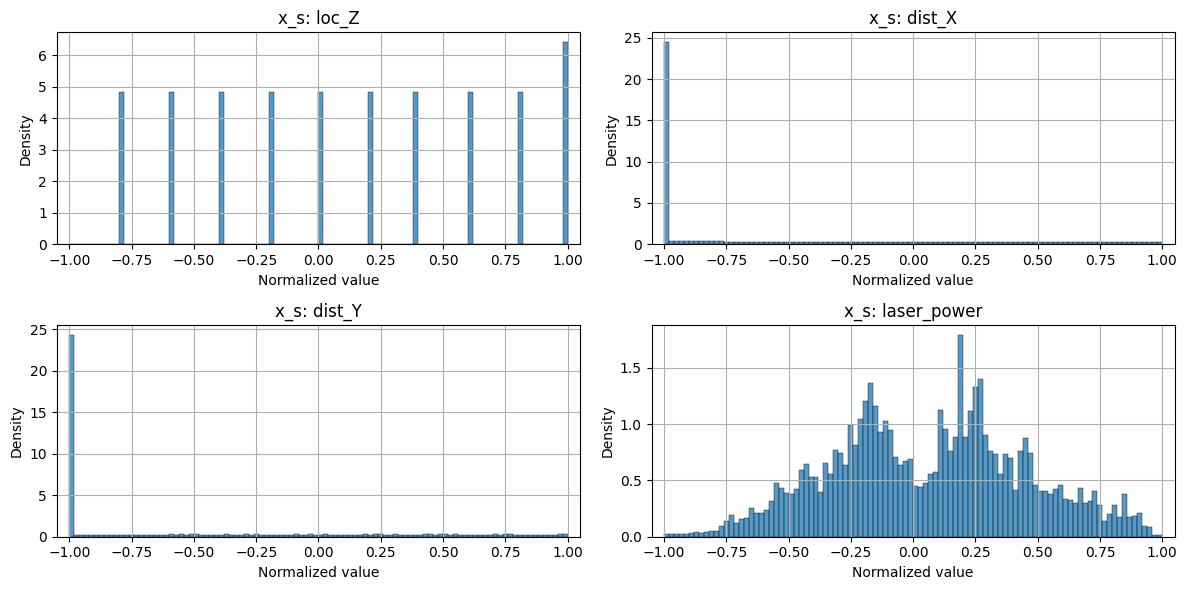

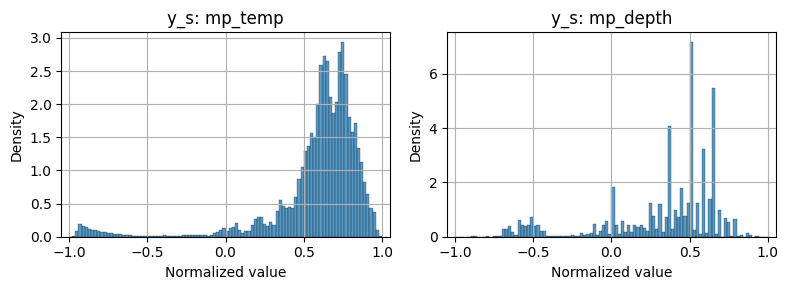

In [167]:
x_names = ['loc_Z', 'dist_X', 'dist_Y', 'laser_power']

plt.figure(figsize=(12, 6))
for i in range(x_s.shape[1]):
    plt.subplot(2, 2, i + 1)
    sns.histplot(x_s[:, i], bins=100, binrange=(-1, 1), kde=False, stat='density')
    plt.title(f'x_s: {x_names[i]}')
    plt.xlabel('Normalized value')
    plt.ylabel('Density')
    plt.xlim(-1.05, 1.05)
    plt.grid(True)
plt.tight_layout()
plt.show()

y_names = ['mp_temp', 'mp_depth']

plt.figure(figsize=(8, 3))
for i in range(y_s.shape[1]):
    plt.subplot(1, 2, i + 1)
    sns.histplot(y_s[:, i], bins=100, binrange=(-1, 1), kde=False, stat='density')
    plt.title(f'y_s: {y_names[i]}')
    plt.xlabel('Normalized value')
    plt.ylabel('Density')
    plt.xlim(-1.05, 1.05)
    plt.grid(True)
plt.tight_layout()
plt.show()



In [169]:
# 기본 분할
cutoff_index = int(np.round(0.9 * x_s.shape[0]))
x_train, y_train = x_s[:cutoff_index], y_s[:cutoff_index]
x_val, y_val = x_s[cutoff_index:], y_s[cutoff_index:]
# y_ref_train, y_ref_val = y_s_ref[:cutoff_index], y_s_ref[cutoff_index:]
y_const_train, y_const_val = y_s_const[:cutoff_index], y_s_const[cutoff_index:]

window = 50
P = 50

# ------------------ Training set ------------------
n_train = cutoff_index - P - window
x_past_train = np.empty((n_train, window, 4))
y_past_train = np.empty((n_train, window, 2))
x_future_train = np.empty((n_train, P, 3))
y_ref_train_seq = np.empty((n_train, P, 1))
y_const_train_seq = np.empty((n_train, P, 2))

for i in tqdm(range(window, cutoff_index - P)):
    j = i - window
    x_past_train[j] = x_train[i-window:i]
    y_past_train[j] = y_train[i-window:i]
    x_future_train[j] = x_train[i:i+P, :3]         # 앞에서 3개
    y_ref_train_seq[j] = y_train[i:i+P, :1]  
    # y_ref_train_seq[j] = y_ref_train[i:i+P]
    y_const_train_seq[j] = y_const_train[i:i+P]

# ------------------ Validation set ------------------
val_cutoff = x_s.shape[0] - cutoff_index
n_val = val_cutoff - P - window
x_past_val = np.empty((n_val, window, 4))
y_past_val = np.empty((n_val, window, 2))
x_future_val = np.empty((n_val, P, 3))
y_ref_val_seq = np.empty((n_val, P, 1))
y_const_val_seq = np.empty((n_val, P, 2))

for i in tqdm(range(window, val_cutoff - P)):
    j = i - window
    x_past_val[j] = x_val[i-window:i]
    y_past_val[j] = y_val[i-window:i]
    x_future_val[j] = x_val[i:i+P, :3]
    y_ref_val_seq[j] = y_val[i:i+P, :1]  
    # y_ref_val_seq[j] = y_ref_val[i:i+P]
    y_const_val_seq[j] = y_const_val[i:i+P]

x_past_train = torch.tensor(x_past_train, dtype=torch.float32)
y_past_train = torch.tensor(y_past_train, dtype=torch.float32)
x_future_train = torch.tensor(x_future_train, dtype=torch.float32)
y_ref_train_seq = torch.tensor(y_ref_train_seq, dtype=torch.float32)
y_const_train_seq = torch.tensor(y_const_train_seq, dtype=torch.float32)

print("x_past shape : ", x_past_train.shape)       # (n_train, 50, 4)
print("y_past shape : ",y_past_train.shape)       # (n_train, 50, 2)
print("x_future shape : ",x_future_train.shape)     # (n_train, 50, 3)
print("y_ref shape : ",y_ref_train_seq.shape)    # (n_train, 50, 1)
print("y_const shape : ",y_const_train_seq.shape)  # (n_train, 50, 2)

x_past_val = torch.tensor(x_past_val, dtype=torch.float32)
y_past_val = torch.tensor(y_past_val, dtype=torch.float32)
x_future_val = torch.tensor(x_future_val, dtype=torch.float32)
y_ref_val_seq = torch.tensor(y_ref_val_seq, dtype=torch.float32)
y_const_val_seq = torch.tensor(y_const_val_seq, dtype=torch.float32)

print("x_past_val shape : ", x_past_val.shape)       # (n_val, 50, 4)
print("y_past_val shape : ", y_past_val.shape)       # (n_val, 50, 2)
print("x_future_val shape : ", x_future_val.shape)   # (n_val, 50, 3)
print("y_ref_val shape : ", y_ref_val_seq.shape)     # (n_val, 50, 1)
print("y_const_val shape : ", y_const_val_seq.shape) # (n_val, 50, 2)




100%|██████████| 60942/60942 [00:00<00:00, 242354.66it/s]


x_past shape :  torch.Size([549275, 50, 4])
y_past shape :  torch.Size([549275, 50, 2])
x_future shape :  torch.Size([549275, 50, 3])
y_ref shape :  torch.Size([549275, 50, 1])
y_const shape :  torch.Size([549275, 50, 2])
x_past_val shape :  torch.Size([60942, 50, 4])
y_past_val shape :  torch.Size([60942, 50, 2])
x_future_val shape :  torch.Size([60942, 50, 3])
y_ref_val shape :  torch.Size([60942, 50, 1])
y_const_val shape :  torch.Size([60942, 50, 2])


In [170]:
def plot_kth_sample_simple(k, x_past, y_past, x_future, y_ref, title=""):
    time_past = np.arange(50)
    time_future = np.arange(50, 100)

    plt.figure(figsize=(12, 6))

    # 1. x_past + x_future (Z, DistX, DistY, Control)
    plt.subplot(2, 1, 1)
    plt.plot(time_past, x_past[k,:,0], label="Z (past)")
    plt.plot(time_past, x_past[k,:,1], label="Dist X (past)")
    plt.plot(time_past, x_past[k,:,2], label="Dist Y (past)")
    plt.plot(time_past, x_past[k,:,3], label="Control (past)")

    plt.plot(time_future, x_future[k,:,0], '--', label="Z (future)")
    plt.plot(time_future, x_future[k,:,1], '--', label="Dist X (future)")
    plt.plot(time_future, x_future[k,:,2], '--', label="Dist Y (future)")

    plt.ylabel("x inputs")
    plt.legend()
    plt.grid()

    # 2. y_past + y_ref (Temp, Depth)
    plt.subplot(2, 1, 2)
    plt.plot(time_past, y_past[k,:,0], label="Temp (past)")
    plt.plot(time_past, y_past[k,:,1], label="Depth (past)")

    plt.plot(time_future, y_ref[k,:,0], '--', label="Temp (ref future)")

    plt.xlabel("Time")
    plt.ylabel("y outputs")
    plt.legend()
    plt.grid()

    plt.suptitle(f"{title} sample #{k}")
    plt.tight_layout()
    plt.show()


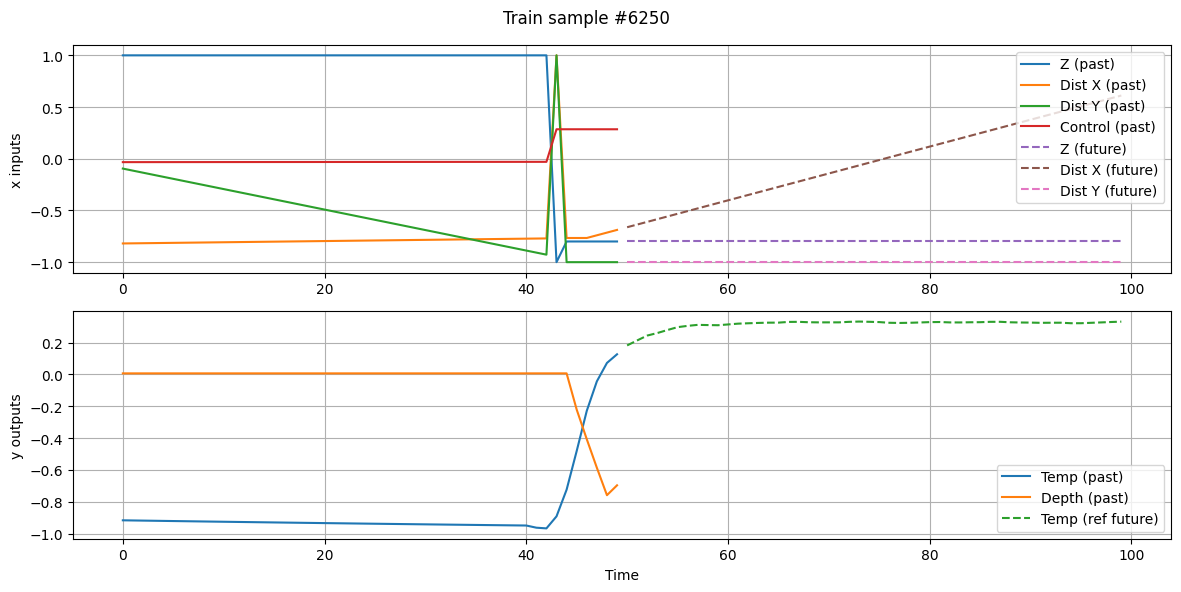

In [171]:
plot_kth_sample_simple(
    k=6250,
    x_past=x_past_train.numpy(),
    y_past=y_past_train.numpy(),
    x_future=x_future_train.numpy(),
    y_ref=y_ref_train_seq.numpy(),
    title="Train"
)


In [172]:
import torch
import pickle

# Load model
with open('TiDE_params_single_track_square_MV_temp_depth_less_cov_0915_w50_p50.pkl', 'rb') as file:
    nominal_params = pickle.load(file)

TiDE = nominal_params['model'].to(device)
total_params = sum(p.numel() for p in TiDE.parameters())
print(f'Total number of parameters: {total_params}')
print(TiDE)

# Extract model dimensions
input_chunk_length = TiDE.input_chunk_length
output_chunk_length = TiDE.output_chunk_length
input_dim = TiDE.input_dim
output_dim = TiDE.output_dim
past_cov_dim = TiDE.past_cov_dim
future_cov_dim = TiDE.future_cov_dim
static_cov_dim = TiDE.static_cov_dim
nr_params = TiDE.nr_params

print("input_chunk_length:", input_chunk_length)
print("output_chunk_length:", output_chunk_length)
print("input_dim:", input_dim)
print("output_dim:", output_dim)
print("past_cov_dim:", past_cov_dim)
print("future_cov_dim:", future_cov_dim)
print("static_cov_dim:", static_cov_dim)
print("nr_params:", nr_params)

# Generate dummy input
B = 1  # batch size
x_past = torch.randn(B, input_chunk_length, input_dim)
x_future_covariates = torch.randn(B, output_chunk_length, future_cov_dim) if future_cov_dim > 0 else None
x_static_covariates = torch.randn(B, static_cov_dim) if static_cov_dim > 0 else None

# Move to device
x_past = x_past.to(device)
if x_future_covariates is not None:
    x_future_covariates = x_future_covariates.to(device)
if x_static_covariates is not None:
    x_static_covariates = x_static_covariates.to(device)

# Run model
x_in = (x_past, x_future_covariates, x_static_covariates)
y = TiDE(x_in)

# Print shapes
print("Input shape:")
print("  x_past:", x_past.shape)
if x_future_covariates is not None:
    print("  x_future_covariates:", x_future_covariates.shape)
if x_static_covariates is not None:
    print("  x_static_covariates:", x_static_covariates.shape)

print("Output shape:", y.shape)  # (B, output_chunk_length, output_dim, nr_params)

Total number of parameters: 796594
TideModule(
  (future_cov_projection): ResidualBlock(
    (dense): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=4, bias=True)
      (3): Dropout(p=0.2, inplace=False)
    )
    (skip): Linear(in_features=4, out_features=4, bias=True)
    (layer_norm): LayerNorm((4,), eps=1e-05, elementwise_affine=True)
  )
  (encoders): Sequential(
    (0): ResidualBlock(
      (dense): Sequential(
        (0): Linear(in_features=500, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): Dropout(p=0.2, inplace=False)
      )
      (skip): Linear(in_features=500, out_features=128, bias=True)
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (decoders): Sequential(
    (0): ResidualBlock(
      (dense): Sequential(
        (0): Linear(in_features=128, out_features=128,

In [173]:
batch_size = 512

# Make sure your training/validation tensors are torch.Tensor before this line
train_dataset = TensorDataset(x_past_train, y_past_train, x_future_train, y_ref_train_seq, y_const_train_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(x_past_val, y_past_val, x_future_val, y_ref_val_seq, y_const_val_seq)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [114]:
def DPC_loss(tide_output: torch.Tensor, reference: torch.Tensor, u_output: torch.Tensor, constraint: torch.Tensor):
    tide_output = tide_output.median(dim=-1).values
    tide_output_temp = tide_output[:, :, 0]
    reference = reference[:, :, 0]
    tracking_loss = (reference - tide_output_temp) ** 2
    mean_loss_per_step = tracking_loss.mean(dim=0).detach().cpu().numpy()
    # print("tracking_loss (mean over batch, per time step):", np.round(mean_loss_per_step, 4))

    u_diff = u_output[:, 1:, :] - u_output[:, :-1, :]
    smoothness_loss = u_diff ** 2


    tide_output_depth = tide_output[:, :, 1]
    low_violation = torch.relu(constraint[:, :, 0] - tide_output_depth) ** 2
    up_violation = torch.relu(tide_output_depth - constraint[:, :, 1]) ** 2
    constraint_loss = low_violation + up_violation

    tracking_loss_sqrt = torch.sqrt(tracking_loss.mean())
    smoothness_loss_sqrt = 0.1 * torch.sqrt(smoothness_loss.mean())
    constraint_loss_sqrt = 3 * torch.sqrt(constraint_loss.mean())
    
    return tracking_loss_sqrt + smoothness_loss_sqrt + constraint_loss_sqrt


In [115]:
import pickle
import os

def train_and_evaluate(n_layers, hidden_dim, setting_name):
    model = PolicyNN(
        past_input_dim=6,
        future_input_dim=6,
        output_dim=1,
        p=50,
        window=50,
        hidden_dim=hidden_dim,
        n_layers=n_layers
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95)

    best_model = None
    best_val_loss = float("inf")
    save_train_loss = np.zeros(num_epoch)
    save_val_loss = np.zeros(num_epoch)
    counter = 0

    with tqdm(total=num_epoch, desc=setting_name) as pbar:
        for epoch in range(num_epoch):
            # model.train()
            for x_past, y_past, x_future, y_ref, y_const in train_loader:
                x_past, y_past, x_future, y_ref, y_const = x_past.to(device), y_past.to(device), x_future.to(device), y_ref.to(device), y_const.to(device)

                policy_in_past = torch.cat((x_past, y_past), dim=2)
                policy_in_future = torch.cat((x_future, y_ref, y_const), dim=2)

                model.train()
                optimizer.zero_grad()

                u_output = model((policy_in_past, policy_in_future))
                x_future_tide = torch.cat((x_future, u_output), dim=2)
                past_cov = torch.cat((y_past, x_past), dim=2) ## 수정함

                tide_pred = TiDE((past_cov, x_future_tide, None))
                loss = DPC_loss(tide_pred, y_ref, u_output, y_const)

                loss.backward()
                optimizer.step()

            # validation
            model.eval()
            val_loss_total = 0.0
            num_val_batches = 0

            with torch.no_grad():
                for val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const in val_loader:
                    val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const = \
                        val_x_past.to(device), val_y_past.to(device), val_x_future.to(device), val_y_ref.to(device), val_y_const.to(device)

                    val_policy_in_past = torch.cat((val_x_past, val_y_past), dim=2)
                    val_policy_in_fut = torch.cat((val_x_future, val_y_ref, val_y_const), dim=2)

                    val_u_output = model((val_policy_in_past, val_policy_in_fut))

                    x_future_tide_val = torch.cat((val_x_future, val_u_output), dim=2)
                    past_cov_val = torch.cat((val_y_past, val_x_past), dim=2) ## 수정함

                    val_tide_pred = TiDE((past_cov_val, x_future_tide_val, None))
                    val_loss = DPC_loss(val_tide_pred, val_y_ref, val_u_output, val_y_const)

                    val_loss_total += val_loss.item()
                    num_val_batches += 1

            val_loss_avg = val_loss_total / num_val_batches

            if val_loss_avg < best_val_loss:
                best_val_loss = val_loss_avg
                best_model = model.state_dict()
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    break

            save_train_loss[epoch] = loss.item()
            save_val_loss[epoch] = val_loss_avg
            scheduler.step()
            pbar.set_description(f"{setting_name} | Epoch {epoch} | Train: {loss.item():.4f} | Val: {val_loss_avg:.4f}")
            pbar.update(1)

    # Save model
    model_path = f"policy_model_0702_allloss_{setting_name}.pth"
    torch.save(best_model, model_path)
    print(f"Saved model to: {os.path.abspath(model_path)}")

    # Save model parameters as .pkl
    model_params = {
        "model_name": setting_name,
        "past_input_dim": 6,
        "future_input_dim": 6,
        "output_dim": 1,
        "future_cov_dim": 2,
        "static_cov_dim": 0,
        "window": 50,
        "p": 50,
        "hidden_dim": hidden_dim,
        "n_layers": n_layers,
        "learning_rate": learning_rate,
        "weight_decay": weight_decay,
        "num_epoch": num_epoch
    }

    param_path = f"policy_parameters_0702_allloss_{setting_name}.pkl"
    with open(param_path, "wb") as f:
        pickle.dump(model_params, f)
    print(f"Saved model parameters to: {os.path.abspath(param_path)}")

    return {
        "train_loss": save_train_loss,
        "val_loss": save_val_loss
    }


In [116]:
import torch
import os
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import numpy as np
import pickle
from policy import PolicyNN

# Hyperparameters
layer_list = [3]
hidden_dim_list = [1024]
num_epoch = 100
batch_size = 512
learning_rate = 1e-3
weight_decay = 1e-5
patience = 100

# Run training and evaluation for each configuration
results = {}

for n_layers in layer_list:
    for hidden_dim in hidden_dim_list:
        setting_name = f"{n_layers}L_{hidden_dim}H"
        print(f"\n▶ Training model: {setting_name}")
        result = train_and_evaluate(n_layers, hidden_dim, setting_name)
        results[setting_name] = result




▶ Training model: 3L_1024H


3L_1024H | Epoch 99 | Train: 0.6670 | Val: 0.3698: 100%|██████████| 100/100 [25:47<00:00, 15.48s/it]

Saved model to: /home/ftk3187/github/DPC_research/02_DED/2_policy/policy_model_0702_allloss_3L_1024H.pth
Saved model parameters to: /home/ftk3187/github/DPC_research/02_DED/2_policy/policy_parameters_0702_allloss_3L_1024H.pkl


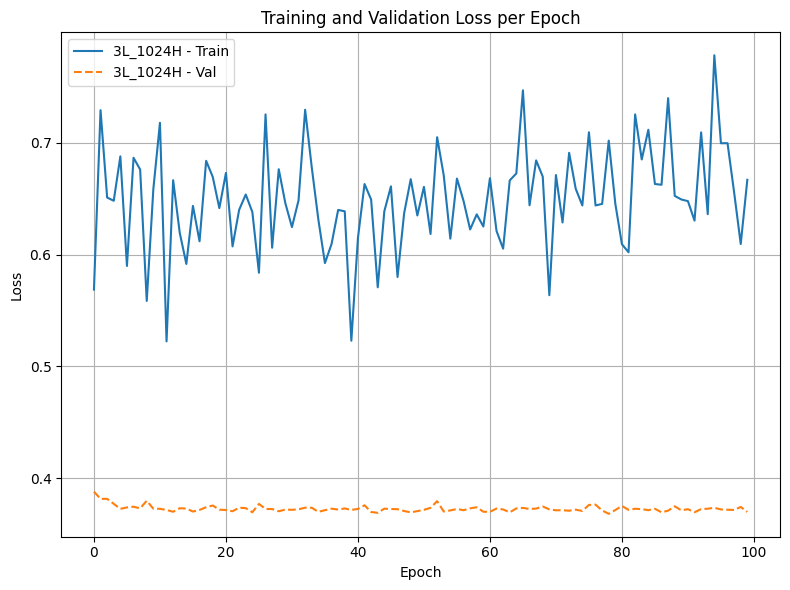

In [117]:
import matplotlib.pyplot as plt

# Plot training and validation loss for each setting
plt.figure(figsize=(8, 6))

for setting_name, result in results.items():
    plt.plot(result['train_loss'], label=f"{setting_name} - Train")
    plt.plot(result['val_loss'], label=f"{setting_name} - Val", linestyle='--')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [193]:
from policy import PolicyNN

model_existingplot = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=50,
    window=50,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)

model_existingplot.load_state_dict(torch.load("policy_model_0630_onlytracking_3L_1024H.pth", map_location=device))
model_existingplot.eval()


PolicyNN(
  (input_layer): Linear(in_features=600, out_features=1024, bias=True)
  (input_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (norm_layers): ModuleList(
    (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=1024, out_features=50, bias=True)
)

In [119]:
from policy import PolicyNN

model = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=50,
    window=50,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)

model.load_state_dict(torch.load("policy_model_test.pth", map_location=device))
model.eval()


PolicyNN(
  (input_layer): Linear(in_features=600, out_features=1024, bias=True)
  (input_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (norm_layers): ModuleList(
    (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=1024, out_features=50, bias=True)
)

In [205]:
from policy import PolicyNN

model_existingplot_withconstraint = PolicyNN(
    past_input_dim=6,
    future_input_dim=6,
    output_dim=1,
    p=50,
    window=50,
    hidden_dim=1024,
    n_layers=3,
    dropout_p=0.1
).to(device)

model_existingplot_withconstraint.load_state_dict(torch.load("policy_model_0702_allloss_3L_1024H_s0.2_c10.0.pth", map_location=device))
model_existingplot_withconstraint.eval()


PolicyNN(
  (input_layer): Linear(in_features=600, out_features=1024, bias=True)
  (input_ln): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (norm_layers): ModuleList(
    (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=1024, out_features=50, bias=True)
)

In [194]:
def plot_val_sample_policy_TiDE(k, model, TiDE, val_x_past, val_y_past, val_x_future, val_y_ref, val_y_const, device, title="", model_name=""):
    model.eval()
    TiDE.eval()

    with torch.no_grad():
        x_past = val_x_past[k:k+1].to(device)
        y_past = val_y_past[k:k+1].to(device)
        x_future = val_x_future[k:k+1].to(device)
        y_ref = val_y_ref[k:k+1].to(device)
        y_const = val_y_const[k:k+1].to(device)

        policy_in_past = torch.cat((x_past, y_past), dim=2)
        policy_in_fut = torch.cat((x_future, y_ref, y_const), dim=2)

        u_pred = model((policy_in_past, policy_in_fut))  # [1, P, 1]

        x_future_tide = torch.cat((x_future, u_pred), dim=2)
        past_cov = torch.cat((y_past, x_past), dim=2)

        y_pred_all = TiDE((past_cov, x_future_tide, None))  # [1, P, 2, 3]

    u_pred = u_pred.squeeze(0).cpu().numpy()                      # [P, 1]
    y_pred = y_pred_all[:, :, :, 1].squeeze(0).cpu().numpy()     # [P, 2] (50% quantile)
    y_ref = y_ref.squeeze(0).cpu().numpy()                       # [P, 2]
    y_past = y_past.squeeze(0).cpu().numpy()                     # [window, 2]
    x_past_np = x_past[0].cpu().numpy()                          # [window, 4]

    time_past = np.arange(50)
    time_future = np.arange(50, 100)

    plt.figure(figsize=(12, 10))

    # Plot 1: Control
    plt.subplot(3, 1, 1)
    control_past = x_past_np[:, 3]
    control_all = np.concatenate([control_past, u_pred.squeeze(-1)])
    plt.plot(np.arange(100), control_all, label="Control (past + predicted)")
    plt.axvline(49, color='gray', linestyle='--', linewidth=1)
    plt.ylabel("Control")
    plt.grid()
    plt.legend()

    # Plot 2: Temp
    plt.subplot(3, 1, 2)
    plt.plot(time_past, y_past[:, 0], label="Temp (past)")
    plt.plot(time_future, y_ref[:, 0], '--', label="Temp (ref)")
    plt.plot(time_future, y_pred[:, 0], label="Temp (pred)")
    plt.ylabel("Temperature")
    plt.grid()
    plt.legend()

    # Plot 3: Depth
    plt.subplot(3, 1, 3)
    plt.plot(time_past, y_past[:, 1], label="Depth (past)")
    # plt.plot(time_future, y_ref[:, 1], '--', label="Depth (ref)")
    plt.plot(time_future, y_pred[:, 1], label="Depth (pred)")
    plt.xlabel("Time")
    plt.ylabel("Depth")
    plt.grid()
    plt.legend()

    plt.suptitle(f"{title} sample #{k}, model: {model_name}")
    plt.tight_layout()
    plt.show()

    # Difference 계산 및 출력
    abs_diff = np.abs(y_pred - y_ref)  # [P, 2]
    mae = np.mean(abs_diff, axis=0)
    mse = np.mean((y_pred - y_ref) ** 2, axis=0)
    rmse = np.sqrt(mse)

    print(f"Sample #{k}, Model: {model_name}")
    print(f"  Temp  MAE: {mae[0]:.4f}, RMSE: {rmse[0]:.4f}")
    print(f"  Depth MAE: {mae[1]:.4f}, RMSE: {rmse[1]:.4f}")


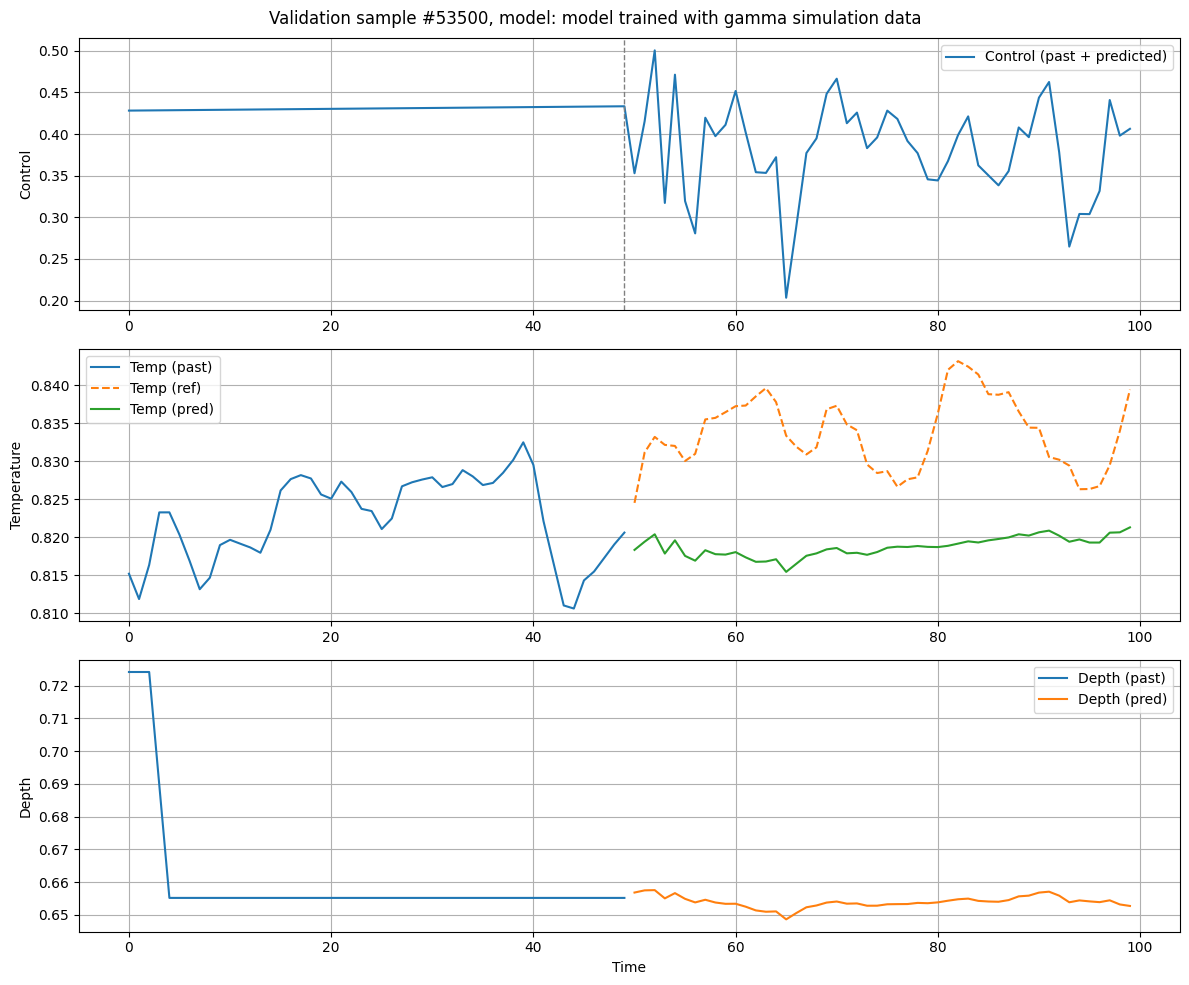

Sample #53500, Model: model trained with gamma simulation data
  Temp  MAE: 0.0149, RMSE: 0.0157
  Depth MAE: 0.1797, RMSE: 0.1798


In [211]:
plot_val_sample_policy_TiDE(
    k=53500,
    model=model_existingplot,
    TiDE=TiDE,
    val_x_past=x_past_val,
    val_y_past=y_past_val,
    val_x_future=x_future_val,
    val_y_ref=y_ref_val_seq,
    val_y_const=y_const_val_seq,
    device=device,
    title="Validation",
    model_name="model trained with gamma simulation data"
)


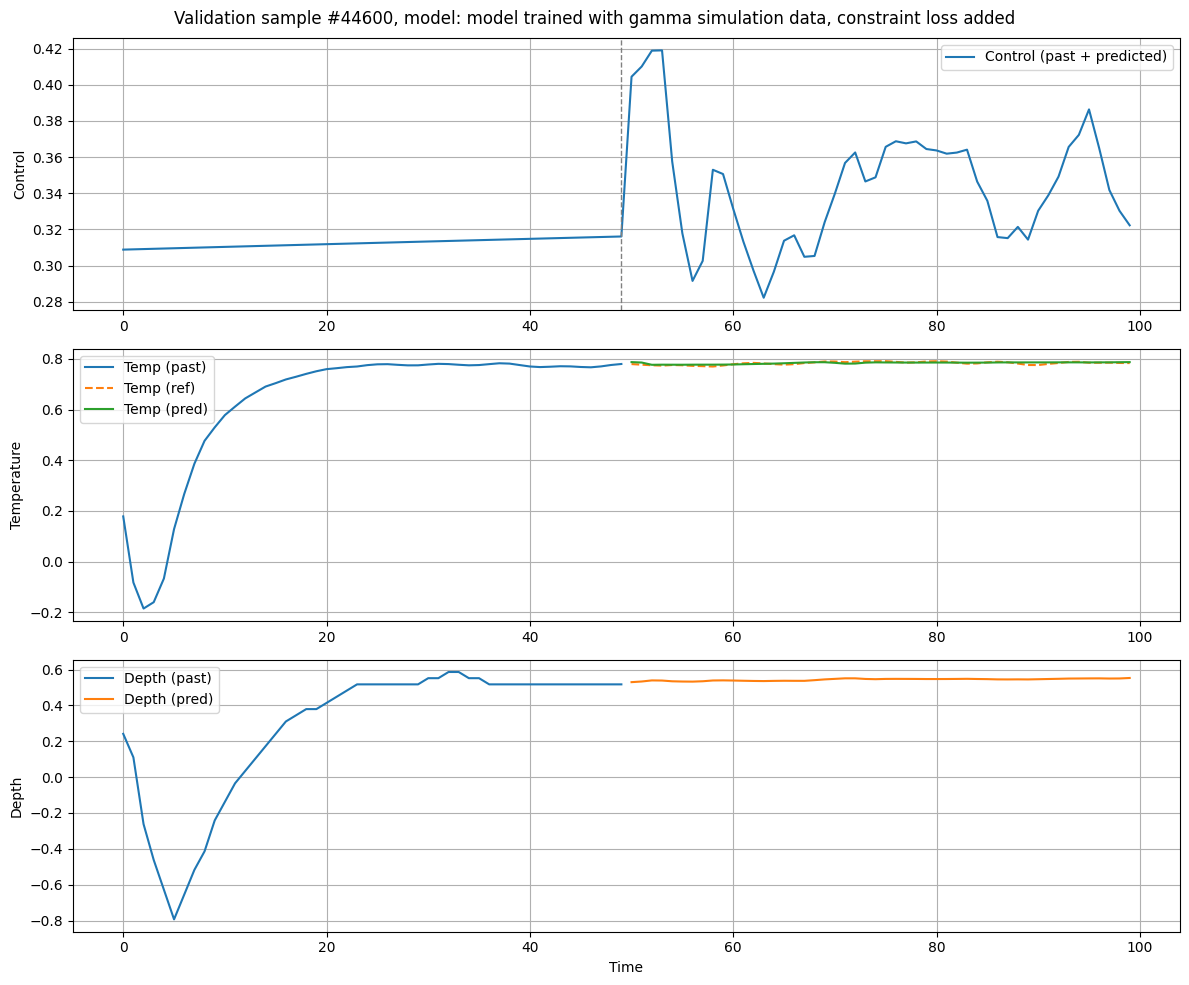

Sample #44600, Model: model trained with gamma simulation data, constraint loss added
  Temp  MAE: 0.0037, RMSE: 0.0044
  Depth MAE: 0.2390, RMSE: 0.2391


In [218]:
plot_val_sample_policy_TiDE(
    k=44600,
    model=model_existingplot_withconstraint,
    TiDE=TiDE,
    val_x_past=x_past_val,
    val_y_past=y_past_val,
    val_x_future=x_future_val,
    val_y_ref=y_ref_val_seq,
    val_y_const=y_const_val_seq,
    device=device,
    title="Validation",
    model_name="model trained with gamma simulation data, constraint loss added"
)


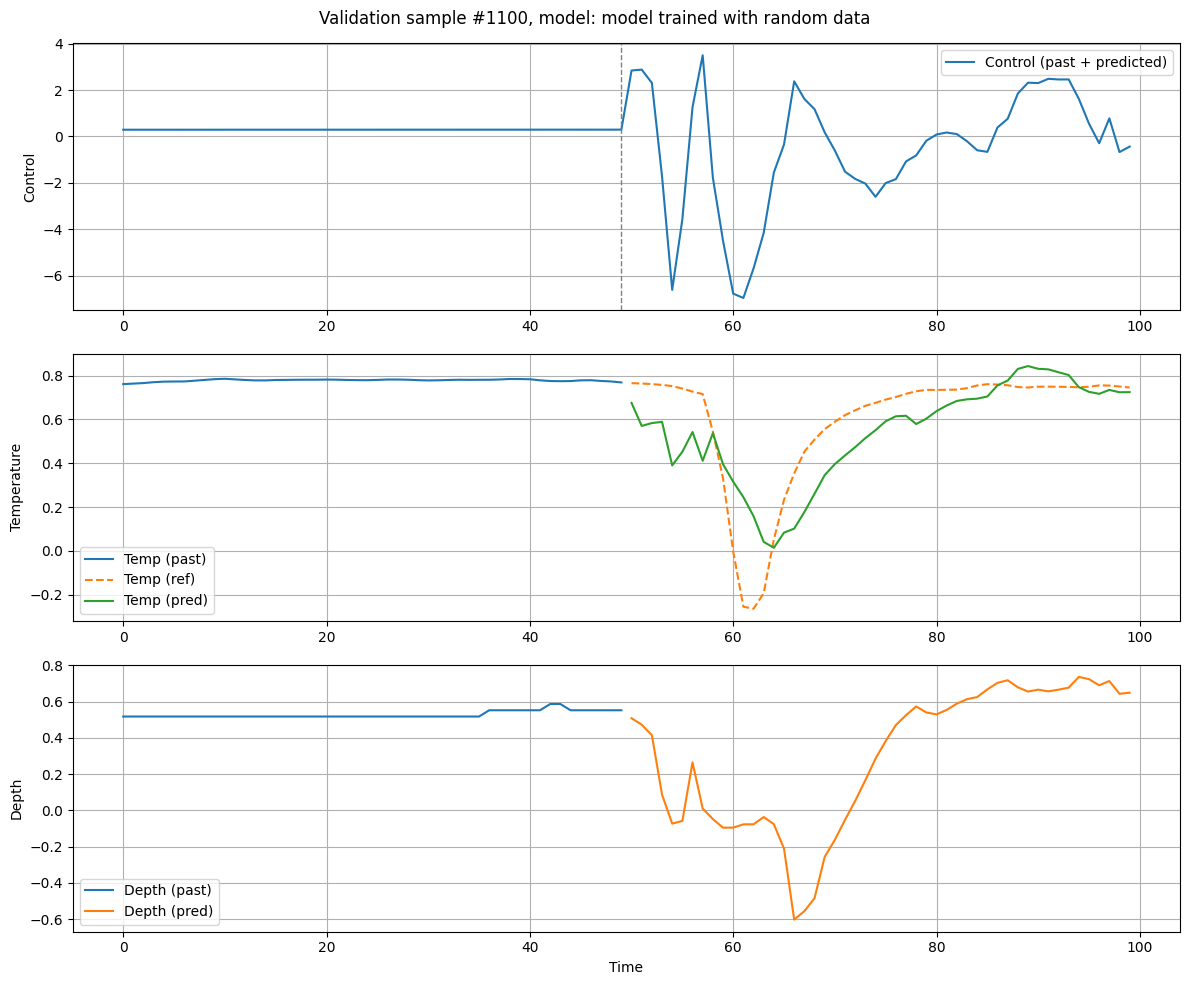

Sample #1100, Model: model trained with random data
  Temp  MAE: 0.1376, RMSE: 0.1775
  Depth MAE: 0.3229, RMSE: 0.4335


In [199]:
plot_val_sample_policy_TiDE(
    k=1100,
    model=model,
    TiDE=TiDE,
    val_x_past=x_past_val,
    val_y_past=y_past_val,
    val_x_future=x_future_val,
    val_y_ref=y_ref_val_seq,
    val_y_const=y_const_val_seq,
    device=device,
    title="Validation",
    model_name="model trained with random data"
)


In [1]:
import matplotlib.pyplot as plt
import numpy as np

# y_ref: shape [P, 2]
start_idx = 54500
window = 60000-start_idx
y_ref_slice = y_ref_val_seq[start_idx : start_idx + window]

time_future = np.arange(start_idx, start_idx + window)

plt.figure(figsize=(10, 4))
plt.plot(time_future, y_ref_slice[:, 0], label="Temp (reference)")
plt.plot(time_future, y_ref_slice[:, 1], label="Depth (reference)")
plt.xlabel("Time step")
plt.ylabel("Reference values")
plt.title("Reference trajectories (y_ref)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'y_ref_val_seq' is not defined